<a href="https://colab.research.google.com/github/kozoB/unsupervised-feature-extraction-of-aerial-images-for-clustering/blob/main/Unsupervised_Feature_Extraction_of_Aerial_Images_for_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Feature Extraction of Aerial Images for Clustering

This project implements the core method from the paper “Unsupervised feature extraction of aerial images for clustering and understanding hazardous road segments” using "Aerial Imagery Semantic Segmentation Dataset" from Kaggle. The goal is to learn unsupervised latent features from aerial images that capture differences in the built environment - such as roads, residential areas, natural landscapes, and infrastructure - and to cluster these images into meaningful groups without any labels. We load and preprocess the images, train a convolutional autoencoder to learn compressed feature representations, reduce the features with PCA, and perform Agglomerative Clustering to identify visually and semantically coherent categories of urban form, reproducing the paper’s feature extraction and clustering pipeline on a different open aerial imagery dataset

## Retrieve Dataset From Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d ransakaravihara/aerial-imagery-semantic-segmentation-dataset
!unzip aerial-imagery-semantic-segmentation-dataset.zip -d aerial_data

## Load Dataset

Using "Aerial Imagery Semantic Segmentation Dataset" from kaggle

In [3]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# set image directory
image_dir = 'aerial_data/images'

# get all image paths
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

print(f"Found {len(image_paths)} images")

# Load and preprocess
def load_image(path, size=(128,128)):
    img = Image.open(path).convert('RGB')
    img = img.resize(size)
    return np.array(img) / 255.0

images = np.array([load_image(p) for p in image_paths])

print(f"Shape of dataset: {images.shape}")

Found 1305 images
Shape of dataset: (1305, 128, 128, 3)


## Exploratory Data Analysis (EDA) of Aerial Images

### Visualize random samples

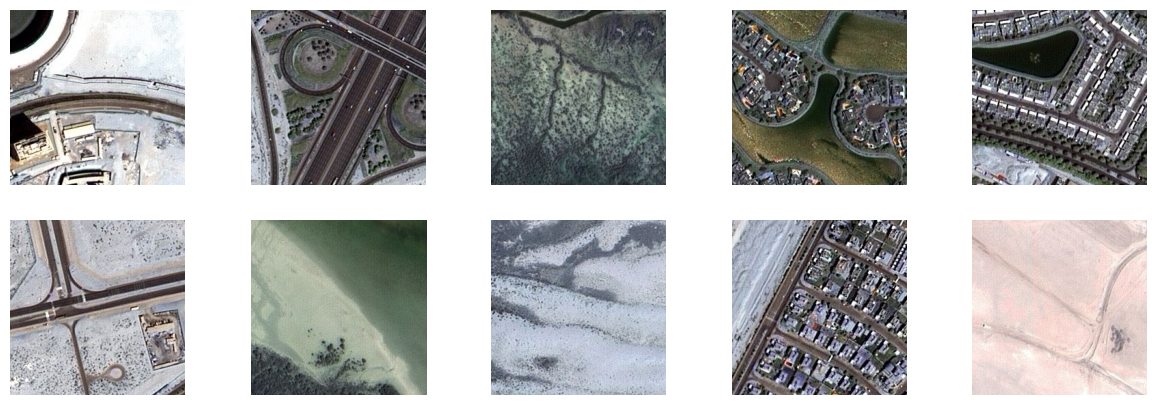

In [12]:
import matplotlib.pyplot as plt
import random

sample_paths = random.sample(image_paths, 10)
plt.figure(figsize=(15,5))
for i, path in enumerate(sample_paths):
    plt.subplot(2,5,i+1)
    plt.imshow(Image.open(path))
    plt.axis('off')
plt.show()

These randomly selected aerial image patches illustrate the variety present in the dataset. They include urban infrastructure such as highways and intersections, planned residential areas with curved streets and water features, natural or undeveloped landscapes with sparse vegetation, and sandy or bare ground regions. Visualizing these samples helps confirm the dataset’s diversity and highlights the range of built environment types that the model will learn to represent

### Check pixel value stats

In [13]:
all_pixels = images.reshape(-1, 3)
print("Min pixel value:", all_pixels.min())
print("Max pixel value:", all_pixels.max())
print("Mean pixel value:", all_pixels.mean())

Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.5408554535756589


The pixel values are properly normalized between 0.0 and 1.0, as expected after scaling. The mean pixel value of approximately 0.54 suggests that the images are overall of moderate brightness, with neither very dark nor extremely light biases dominating the dataset. This indicates good dynamic range in the imagery, which should help the autoencoder learn meaningful visual features

### Plot basic color histograms

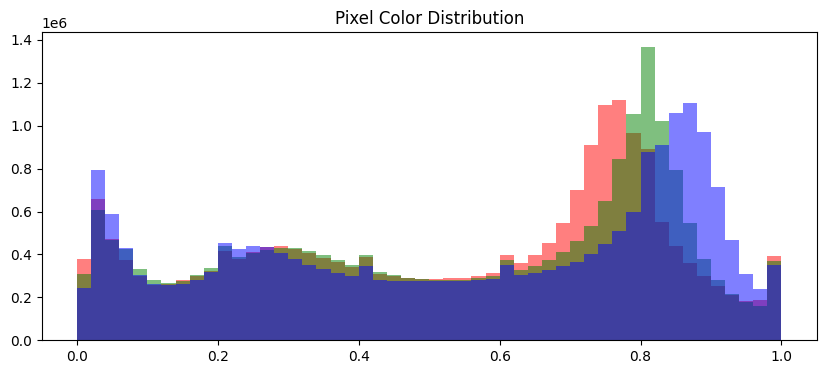

In [15]:
import numpy as np

plt.figure(figsize=(10,4))
colors = ('red', 'green', 'blue')
for i, color in enumerate(colors):
    plt.hist(all_pixels[:,i], bins=50, alpha=0.5, color=color)
plt.title('Pixel Color Distribution')
plt.show()

The histogram shows the distribution of normalized pixel values across the red, green, and blue channels in the dataset. The peaks toward higher values indicate that many image regions are relatively bright, likely representing pale surfaces such as sand, bare ground, or rooftops. The spread across the entire range also suggests varied content, including darker features like roads, water bodies, or vegetation. This diverse color distribution supports the potential for the model to learn rich, meaningful features from the imagery

## Create Model (Convolutional Autoencoder)

We build a convolutional autoencoder (CAE) to learn unsupervised feature representations from aerial images. The autoencoder consists of an encoder that compresses images into low-dimensional latent features, and a decoder that reconstructs the original images from these features. By training the model to minimize reconstruction error, the encoder learns to capture the most important visual structures and patterns in the data without any manual labeling

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Encoder
input_img = layers.Input(shape=(128,128,3))
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(128, activation='relu')(x)

# Decoder
x = layers.Dense(32*32*64, activation='relu')(encoded)
x = layers.Reshape((32,32,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 65536)          │     8,454,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,918,531 (64.54 MB)

 Trainable params: 16,918,531 (64.54 MB)

 Non-trainable params: 0 (0.00 B)

## Train The Autoencoder

In [5]:
history = autoencoder.fit(images, images,
                epochs=20,
                batch_size=16,
                validation_split=0.1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0861 - val_loss: 0.0623
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0603 - val_loss: 0.0520
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0529 - val_loss: 0.0462
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0484 - val_loss: 0.0431
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0443 - val_loss: 0.0411
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0409 - val_loss: 0.0377
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0391 - val_loss: 0.0362
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0381 - val_loss: 0.0346
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0355 - val_loss: 0.0331
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0338 - val_loss: 0.0318
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0329 - val_loss: 0.0309
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.

## Plot Training and Validation Loss

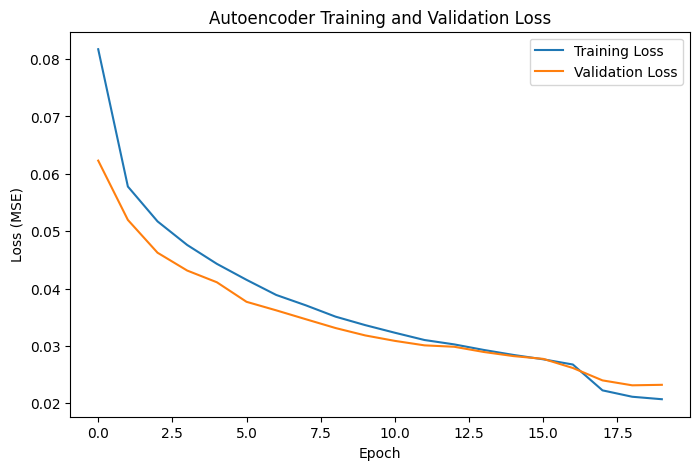

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.show()

The training and validation losses both gradually decrease over epochs, indicating that the autoencoder is successfully learning to reconstruct the input images. This reduction in loss suggests that the model is effectively capturing and encoding important visual features and structures from the aerial imagery into its latent representations

## Extract Latent Features

After training the convolutional autoencoder, we use its encoder part to transform each aerial image into a compact latent feature vector. These latent features capture the essential visual patterns and structures in the images-such as roads, buildings, vegetation, or open land-while discarding irrelevant details. This lower-dimensional representation serves as the basis for meaningful comparison and clustering of similar built environments without any labels

In [7]:
encoder = models.Model(input_img, encoded)
latent_features = encoder.predict(images)
print(latent_features.shape)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
(1305, 128)


## Reduce Dimensions with PCA

We apply Principal Component Analysis (PCA) to the latent features extracted from the autoencoder to reduce their dimensionality before clustering. This step helps simplify the high-dimensional feature space while retaining the most important variation in the data. By projecting the features onto fewer components, PCA makes the clustering process more efficient and robust, ensuring that the resulting groups reflect the dominant patterns in the built environment captured by the model

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
reduced_features = pca.fit_transform(latent_features)
print(reduced_features.shape)

(1305, 10)


## Cluster with Agglomerative Clustering

We apply Agglomerative Clustering to the PCA-reduced latent features to group the aerial image patches into distinct clusters based on visual similarity. This unsupervised step assigns each image to a cluster whose members share similar built environment characteristics, helping us identify meaningful patterns in the data without labels. We chose to use 4 clusters as a reasonable and interpretable number to capture major types of environments in the imagery, such as transport infrastructure, residential areas, natural landscapes, and open or bare land

In [9]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4)
cluster_labels = clustering.fit_predict(reduced_features)

print(np.unique(cluster_labels))

[0 1 2 3]


## Visualize Clusters

To interpret the results of our unsupervised clustering, we visualize sample images from each cluster. By examining these groups side by side, we can see how the model has separated the aerial image patches into meaningful categories with similar built environment features. This qualitative inspection helps confirm that the clustering is capturing patterns such as transport infrastructure, residential layouts, natural landscapes, or open land, even without any labeled data


Cluster 0


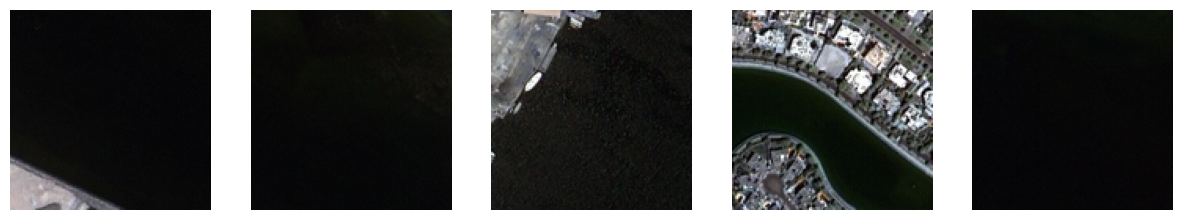


Cluster 1


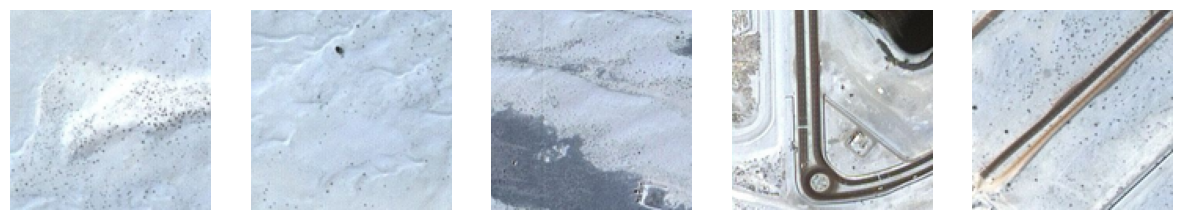


Cluster 2


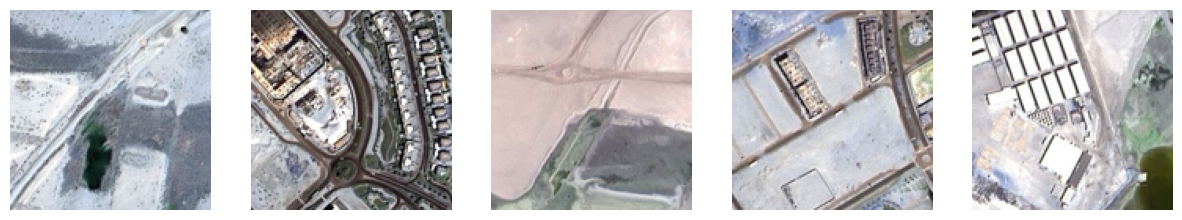


Cluster 3


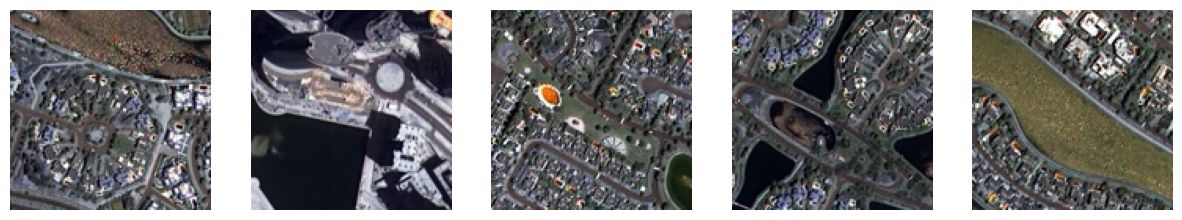

In [10]:
import random

for cluster in np.unique(cluster_labels):
    print(f"\nCluster {cluster}")
    cluster_indices = np.where(cluster_labels == cluster)[0]
    sample_indices = random.sample(list(cluster_indices), min(5, len(cluster_indices)))

    plt.figure(figsize=(15,3))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1,5,i+1)
        plt.imshow(images[idx])
        plt.axis('off')
    plt.show()

 The clustering results show clear grouping of aerial image patches into visually consistent categories.

 One cluster primarily includes dark green and blackish regions that appear to represent large water bodies, coastlines, or dense shadows—capturing non-urban or natural landscapes.


 Another cluster contains pale, sandy, and sparsely developed areas with minimal built structures, consistent with open desert-like terrain, bare ground, or low-density development.

 A third cluster shows mixed-use or transitional areas with road networks, light industrial layouts, and semi-developed parcels, suggesting edge-of-city development or peri-urban zones.

 The final cluster features more structured, planned residential areas with clear street grids, roundabouts, and dense suburban patterns, often interspersed with green spaces or water features.

 These results confirm that the autoencoder's latent features, combined with clustering, can separate distinct types of built environments purely from aerial imagery, without any manual labels